# EEGNet 4 classes

In [1]:
import os
import mne
import math
import copy
import gdown
import random
import scipy.io
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchsummary import summary
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset, random_split

from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
file = "features/cleaned_epoched_eeg.npy"
raw_data  =  np.load(file, allow_pickle=True)
print(raw_data.shape)

(660, 2)


In [3]:
X = np.stack(raw_data[:, 1])  # EEG 
y = raw_data[:, 0].astype(int) #classes
y = y - 1
y = torch.tensor(y, dtype=torch.long) 

X = X[:,:,200*2:200*6] 
X = X[:,:,0:-1:3]

In [4]:
X_np = X

X_mean = np.mean(X_np, axis=(0, 1, 2), keepdims=True)
X_std = np.std(X_np, axis=(0, 1, 2), keepdims=True)
X_normalized = (X_np - X_mean) / X_std

X = torch.tensor(X_normalized, dtype=torch.float32)

In [5]:
print(X.shape)  
print(torch.unique(y))

torch.Size([660, 32, 267])
tensor([0, 1, 2, 3])


In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

criterion = nn.CrossEntropyLoss()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Converting to Tensor
X_train = torch.Tensor(X_train).unsqueeze(1).to(device)
X_test = torch.Tensor(X_test).unsqueeze(1).to(device)
y_train = torch.LongTensor(y_train).to(device)
y_test = torch.LongTensor(y_test).to(device)

# Creating Tensor Dataset
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Printing the sizes
print("Size of X_train:", X_train.size())
print("Size of X_test:", X_test.size())
print("Size of y_train:", y_train.size())
print("Size of y_test:", y_test.size())


Size of X_train: torch.Size([528, 1, 32, 267])
Size of X_test: torch.Size([132, 1, 32, 267])
Size of y_train: torch.Size([528])
Size of y_test: torch.Size([132])


In [7]:
class TrainModel():
    def __init__(self,):
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def train_model(self, model, train_dataset, learning_rate=0.001, batch_size=64, epochs=500):
        model = model.to(self.device)
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        highest_train_accuracy = 0.0

        for epoch in range(epochs):
            model.train()
            running_loss = 0.0
            correct = 0
            total = 0
            for inputs, labels in train_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)

                optimizer.zero_grad()
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            epoch_loss = running_loss / len(train_loader.dataset)
            epoch_accuracy = correct / total
            if epoch_accuracy > highest_train_accuracy:
                highest_train_accuracy = epoch_accuracy
            print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}, Accuracy: {(epoch_accuracy*100):.2f}%")

        average_loss = running_loss / len(train_loader.dataset)
        print("Average Loss:", average_loss)
        print("Highest Train Accuracy:", highest_train_accuracy)

        # Saving model
        torch.save(model.state_dict(), 'eegnet_model.pth')
        return model


In [8]:
class EvalModel():
    def __init__(self, model):
        self.model = model.to(device)
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    def test_model(self, test_dataset):
        self.model.eval()
        correct = 0
        total = 0
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = (correct / total) * 100
        print("/------------------------------/")
        print(f"Test Accuracy: {accuracy:.2f}%")
        print("/------------------------------/")
        return accuracy

    def plot_confusion_matrix(self, test_dataset, classes):
        self.model.eval()
        y_pred = []
        y_true = []
        test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

        with torch.no_grad():
            for inputs, labels in test_loader:
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                y_pred.append(predicted.item())
                y_true.append(labels.item())

        cf_matrix = confusion_matrix(y_true, y_pred)
        cf_matrix = cf_matrix.astype('float') / cf_matrix.sum(axis=1)[:, np.newaxis]

        df_cm = pd.DataFrame(cf_matrix, index=classes, columns=classes)

        plt.figure(figsize=(10, 7))
        sn.heatmap(df_cm, annot=True, cmap='Blues', fmt='.2f')
        plt.xlabel('Predicted labels')
        plt.ylabel('True labels')
        plt.title('Confusion Matrix')
        plt.savefig('confusion_matrix_model.png')
        plt.show()


In [9]:
class EEGNetModel(nn.Module): # EEGNET-8,2
    def __init__(self, chans=32, classes=4, time_points=267, temp_kernel=32,
                 f1=16, f2=32, d=2, pk1=8, pk2=16, dropout_rate=0.5, max_norm1=1, max_norm2=0.25):
        super(EEGNetModel, self).__init__()
        # Calculating FC input features
        linear_size = (time_points//(pk1*pk2))*f2

        # Temporal Filters
        self.block1 = nn.Sequential(
            nn.Conv2d(1, f1, (1, temp_kernel), padding='same', bias=False),
            nn.BatchNorm2d(f1),
        )
        # Spatial Filters
        self.block2 = nn.Sequential(
            nn.Conv2d(f1, d * f1, (chans, 1), groups=f1, bias=False), # Depthwise Conv
            nn.BatchNorm2d(d * f1),
            nn.ELU(),
            nn.AvgPool2d((1, pk1)),
            nn.Dropout(dropout_rate)
        )
        self.block3 = nn.Sequential(
            nn.Conv2d(d * f1, f2, (1, 16),  groups=f2, bias=False, padding='same'), # Separable Conv
            nn.Conv2d(f2, f2, kernel_size=1, bias=False), # Pointwise Conv
            nn.BatchNorm2d(f2),
            nn.ELU(),
            nn.AvgPool2d((1, pk2)),
            nn.Dropout(dropout_rate)
        )
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(linear_size, classes)

        # Apply max_norm constraint to the depthwise layer in block2
        self._apply_max_norm(self.block2[0], max_norm1)

        # Apply max_norm constraint to the linear layer
        self._apply_max_norm(self.fc, max_norm2)

    def _apply_max_norm(self, layer, max_norm):
        for name, param in layer.named_parameters():
            if 'weight' in name:
                param.data = torch.renorm(param.data, p=2, dim=0, maxnorm=max_norm)

    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.block3(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x


In [10]:
input_size = (1, 32, 267)
eegnet_model = EEGNetModel().to(device)
summary(eegnet_model, input_size)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32, 267]         --
|    └─Conv2d: 2-1                       [-1, 16, 32, 267]         512
|    └─BatchNorm2d: 2-2                  [-1, 16, 32, 267]         32
├─Sequential: 1-2                        [-1, 32, 1, 33]           --
|    └─Conv2d: 2-3                       [-1, 32, 1, 267]          1,024
|    └─BatchNorm2d: 2-4                  [-1, 32, 1, 267]          64
|    └─ELU: 2-5                          [-1, 32, 1, 267]          --
|    └─AvgPool2d: 2-6                    [-1, 32, 1, 33]           --
|    └─Dropout: 2-7                      [-1, 32, 1, 33]           --
├─Sequential: 1-3                        [-1, 32, 1, 2]            --
|    └─Conv2d: 2-8                       [-1, 32, 1, 33]           512
|    └─Conv2d: 2-9                       [-1, 32, 1, 33]           1,024
|    └─BatchNorm2d: 2-10                 [-1, 32, 1, 33]           64
|    └─

C:\Users\TeraForm\anaconda3\envs\eegnet_env\lib\site-packages\torch\nn\modules\conv.py:454: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv2d(input, weight, bias, self.stride,


Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 16, 32, 267]         --
|    └─Conv2d: 2-1                       [-1, 16, 32, 267]         512
|    └─BatchNorm2d: 2-2                  [-1, 16, 32, 267]         32
├─Sequential: 1-2                        [-1, 32, 1, 33]           --
|    └─Conv2d: 2-3                       [-1, 32, 1, 267]          1,024
|    └─BatchNorm2d: 2-4                  [-1, 32, 1, 267]          64
|    └─ELU: 2-5                          [-1, 32, 1, 267]          --
|    └─AvgPool2d: 2-6                    [-1, 32, 1, 33]           --
|    └─Dropout: 2-7                      [-1, 32, 1, 33]           --
├─Sequential: 1-3                        [-1, 32, 1, 2]            --
|    └─Conv2d: 2-8                       [-1, 32, 1, 33]           512
|    └─Conv2d: 2-9                       [-1, 32, 1, 33]           1,024
|    └─BatchNorm2d: 2-10                 [-1, 32, 1, 33]           64
|    └─

In [11]:
eegnet_model = EEGNetModel().to(device)

# Training Hyperparameters
EPOCHS = 500
BATCH_SIZE = 64
LEARNING_RATE = 0.001
trainer = TrainModel()
trained_eegnet_model = trainer.train_model(eegnet_model, train_dataset, learning_rate=LEARNING_RATE,
                                   batch_size=BATCH_SIZE, epochs=EPOCHS)
torch.save(trained_eegnet_model.state_dict(), 'eegnet_model.pth')


Epoch 1/500, Loss: 1.3874, Accuracy: 26.33%
Epoch 2/500, Loss: 1.3872, Accuracy: 27.08%
Epoch 3/500, Loss: 1.3801, Accuracy: 27.08%
Epoch 4/500, Loss: 1.3679, Accuracy: 33.52%
Epoch 5/500, Loss: 1.3785, Accuracy: 28.03%
Epoch 6/500, Loss: 1.3706, Accuracy: 31.25%
Epoch 7/500, Loss: 1.3572, Accuracy: 33.71%
Epoch 8/500, Loss: 1.3608, Accuracy: 34.28%
Epoch 9/500, Loss: 1.3549, Accuracy: 34.09%
Epoch 10/500, Loss: 1.3421, Accuracy: 34.28%
Epoch 11/500, Loss: 1.3453, Accuracy: 33.14%
Epoch 12/500, Loss: 1.3463, Accuracy: 31.25%
Epoch 13/500, Loss: 1.3202, Accuracy: 38.26%
Epoch 14/500, Loss: 1.3244, Accuracy: 33.52%
Epoch 15/500, Loss: 1.3103, Accuracy: 36.93%
Epoch 16/500, Loss: 1.3014, Accuracy: 35.80%
Epoch 17/500, Loss: 1.2990, Accuracy: 38.26%
Epoch 18/500, Loss: 1.2828, Accuracy: 38.64%
Epoch 19/500, Loss: 1.2895, Accuracy: 36.17%
Epoch 20/500, Loss: 1.2921, Accuracy: 37.31%
Epoch 21/500, Loss: 1.2711, Accuracy: 38.64%
Epoch 22/500, Loss: 1.2708, Accuracy: 40.15%
Epoch 23/500, Loss:

/------------------------------/
Test Accuracy: 42.42%
/------------------------------/


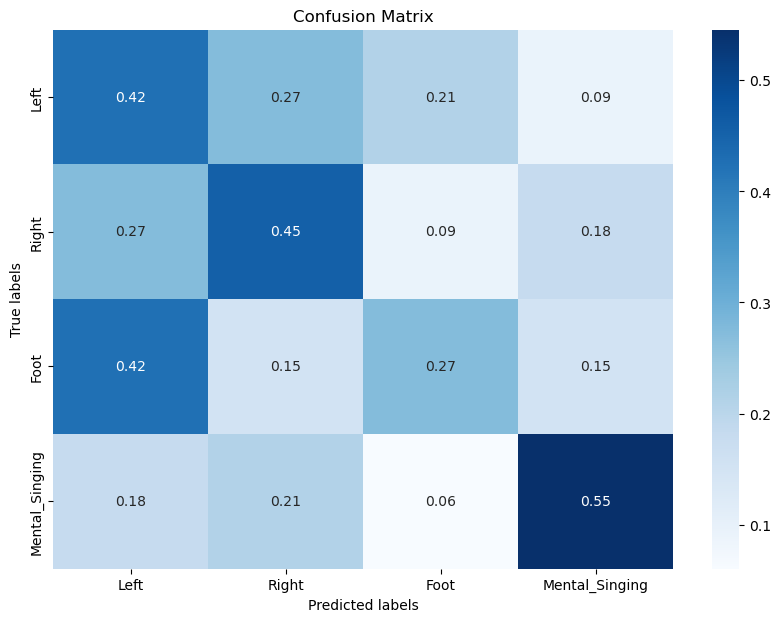

In [12]:
classes_list = ['Left', 'Right', 'Foot', 'Mental_Singing']
eval_model = EvalModel(trained_eegnet_model)
test_accuracy = eval_model.test_model(test_dataset)
eval_model.plot_confusion_matrix(test_dataset, classes_list)
